In [1]:
import logging
from pathlib import Path
import sys
import data_loading
import utils
import explainers
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [4]:
DATASET_NAME = 'hpas' #change data set name

In [5]:
timeseries, labels, test_timeseries, test_labels = \
        data_loading.get_dataset(DATASET_NAME, binary=False)

2021-04-30 11:53:23,065 INFO    Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
100%|██████████| 307/307 [00:28<00:00, 10.91it/s]


In [8]:
extractor = utils.TSFeatureGenerator(threads=1, trim=0)
pipeline = Pipeline([
    ('assert1', utils.CheckFeatures()),
    ('features', utils.TSFeatureGenerator(threads=1, trim=0)),
    ('assert2', utils.CheckFeatures()),
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced'))
], verbose=True)

In [9]:
pipeline.fit(timeseries, labels)

[Pipeline] ........... (step 1 of 5) Processing assert1, total=   0.0s
[Pipeline] .......... (step 2 of 5) Processing features, total=  33.4s
[Pipeline] ........... (step 3 of 5) Processing assert2, total=   0.0s
[Pipeline] ............ (step 4 of 5) Processing scaler, total=   0.2s


/usr3/graduate/baksar/.local/lib/python3.6/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[Pipeline] ............... (step 5 of 5) Processing clf, total=   7.2s


Pipeline(steps=[('assert1', CheckFeatures()),
                ('features', TSFeatureGenerator(threads=1, trim=0)),
                ('assert2', CheckFeatures()),
                ('scaler', MinMaxScaler(feature_range=(-1, 1))),
                ('clf', RandomForestClassifier(class_weight='balanced'))],
         verbose=True)

In [10]:
preds = pipeline.predict(test_timeseries)

F1 score: 0.7495174989369331
	 none 0.8069273440671088
	 dial 0.5150812064965197
	 memeater 1.0
	 network 0.37219533655961284
	 memorybandwidth 0.5088062622309197
	 leak 1.0
	 dcopy 0.7670454545454546


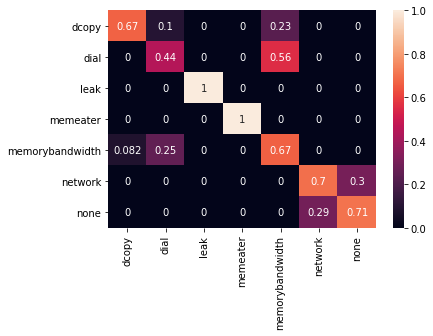

In [11]:
print("F1 score:", f1_score(test_labels, preds, average='weighted'))
for label, i in zip(test_labels['label'].unique(), f1_score(test_labels, preds, labels=test_labels['label'].unique(), average=None)):
    print("\t", label, i)

label_list = pipeline.steps[4][1].classes_
cf = confusion_matrix(test_labels, preds, labels=label_list).astype(float)
for i in range(len(cf)):
    cf[i] = [x / cf[i].sum() for x in cf[i]]
sns.heatmap(cf, annot=True, xticklabels=label_list, yticklabels=label_list)
plt.show()

2021-04-30 12:04:07,032 INFO    Working on turning label from leak to none
2021-04-30 12:05:22,435 INFO    Finished constructing per class kdtree
2021-04-30 12:05:22,455 INFO    Returning distractors ['5c1317081963fd7bbf0f90f8_105', '5c1317081963fd7bbf0f90f8_90']
2021-04-30 12:05:22,456 INFO    Trying distractor 1 / 2
2021-04-30 12:10:02,296 INFO    Current probas: [[0.02 0.   0.64 0.03 0.01 0.13 0.17]]
2021-04-30 12:10:02,299 INFO    Trying distractor 2 / 2
2021-04-30 12:14:49,136 INFO    Current probas: [[0.03 0.01 0.52 0.01 0.01 0.21 0.21]]
2021-04-30 12:14:49,139 INFO    Used greedy search for 5c15428439747d4a8fa8f85d_60
2021-04-30 12:14:49,189 INFO    Working on turning label from 2 to 6
2021-04-30 12:14:49,207 INFO    Returning distractors ['5c1317081963fd7bbf0f90f8_105', '5c1317081963fd7bbf0f90f8_90']
2021-04-30 12:14:49,208 INFO    Trying distractor 1 / 2
2021-04-30 12:14:49,255 INFO    Current probas: [[0.02 0.   0.9  0.   0.   0.05 0.03]]
2021-04-30 12:14:53,373 INFO    Best 

['pgalloc_normal::vmstat',
 'htlb_buddy_alloc_success::vmstat',
 'HugePages_Total::meminfo',
 'CommitLimit::meminfo']

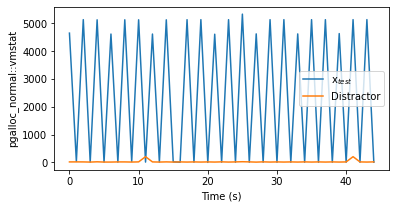

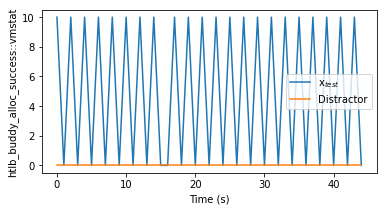

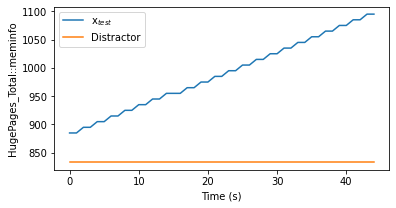

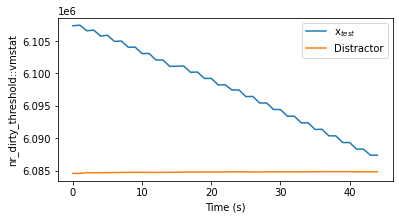

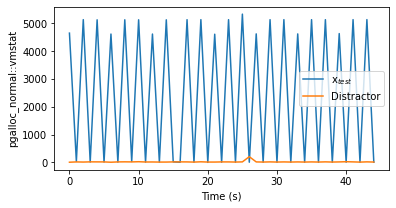

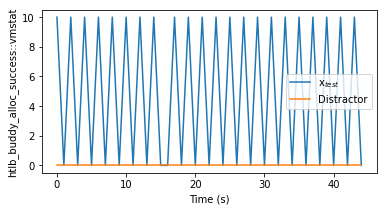

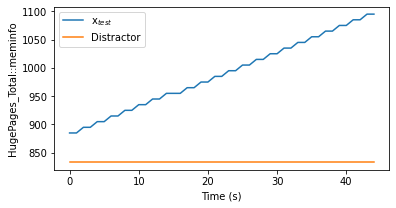

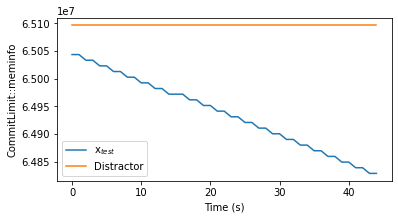

In [16]:
#Convert "memory leak" to "normal" class
comte = explainers.OptimizedSearch(pipeline, timeseries, labels, silent=False, threads=1)
comte.explain(test_timeseries.loc[['5c15428439747d4a8fa8f85d_60'], :, :], to_maximize=6, savefig=False)